# Single-shot Multibox Detector

Este tutorial possui o propósito de relatar os passos seguidos na implementação do SSD para detecção de leucócitos em imagens de vídeo de Microscopia Intravital. Contém os passos necessários para subamostragem dos pesos das camadas de classificação, para o treinamento da rede neural e para realização das predições. 
Este material foi embasado nos repositóros de Bruno Gregório - https://brunoggregorio.github.io/ - e de Pierluigi Ferrari - https://github.com/pierluigiferrari/ssd_keras.

## SSD para detecção de leucócitos

O SSD300 foi, originalmente, treinado no conjunto de dados MS COCO (http://cocodataset.org/#home) e, portanto, prediz 80 classes difentes, enquanto que o objetivo é predizer apenas uma classe - os leucócitos. 
Os pesos dos tensores das camadas de classificação do MS COCO não possuem o formato correto para o modelo de detecção de leucócitos, visto que ele deveria aprender apenas uma classe.

Ajustar um modelo SSD treinado utilizando-se o MS COCO para um conjunto de dados que contém apenas a classe leucócito envolve, inicialmente, subamostrar o arquivo de pesos das camadas de classificação para que seus formatos correspondam ao número de classes do conjunto de dados - 'background' ou fundo e 'cell' ou célula.

Mesmo que 'cell' não seja uma das classes previstas no conjunto de dados MS COCO, é melhor utiliza os pesos do modelo previamente treinado do que começar o treinamento do zero, visto que qualquer arquivo de pesos treinados será melhor que começar o treinamento com inicialização aleatória.

a seguir, serão importadas as bibliotecas necessárias para o procedimento de subamostragem dos pesos:

In [1]:
import h5py
import numpy as np
import shutil

from misc_utils.tensor_sampling_utils import sample_tensors

## 1. Carregar o arquivo de pesos treinados e fazer uma cópia 

Inicialmente, é necessário carregar o arquivo HDF5 que contém os pesos treinados. Ele está disponível através do arquivo README do repositório https://github.com/pierluigiferrari/ssd_keras, juntamente com outros arquivos de pesos. Para este tutorial, foi utilizado o arquivo "`VGG_coco_SSD_300x300_iter_400000.h5`", que corresponde aos pesos do modelo SSD300 treinado no MS COCO.

Em seguida, será feita uma cópia do arquivo de pesos. Este será o arquivo de destino ou arquivo de saída.

In [2]:
# Aqui, seta-se o caminho para o arquivo de pesos fonte.
weights_source_path = 'VGG_coco_SSD_300x300_iter_400000.h5'

# Aqui, seta-se o caminho e o nome do arquivo de pesos destino, ou arquivo de saída.
weights_destination_path = 'VGG_coco_SSD_300x300_iter_400000_subsampled_1_class_b128_e150_scale0.5_bbmodified_trainval.h5'

# Realiza a cópia do arquivo fonte para o arquivo de saída.
shutil.copy(weights_source_path, weights_destination_path)

'VGG_coco_SSD_300x300_iter_400000_subsampled_1_class_b128_e150_scale0.5_bbmodified_trainval.h5'

In [3]:
# Carrega tanto o arquivo fonte quanto o arquivo de saída.
# É boa prática carregar o arquivo original em modo "leitura-apenas" para que não haja sobrescrita.
weights_source_file = h5py.File(weights_source_path, 'r')
weights_destination_file = h5py.File(weights_destination_path)

## 2. Descobrir quais tensores de pesos precisam ser subamostrados

Em seguida, é necessário descobrir quais tensores de pesos precisam ser subamostrados. Os pesos de todas as camadas da rede neural, **exceto pelos pesos das camadas de classificação**, estão corretamente treinados.

As camadas de classificação do SSD300 estão mostradas abaixo:

In [4]:
classifier_names = ['conv4_3_norm_mbox_conf',
                    'fc7_mbox_conf',
                    'conv6_2_mbox_conf',
                    'conv7_2_mbox_conf',
                    'conv8_2_mbox_conf',
                    'conv9_2_mbox_conf']

## 3. Descobrir quais elementos manter

Já foram separadas as camadas que serão subamostradas, o próximo passo é decidir quantos e quais elementos dessas camadas serão mantidos. A primeira camada de classificação, como mostrada acima, é a "`conv4_3_norm_mbox_conf`". Ela possui dois tensores de pesos - o kernel e o bias - que possuem, respectivamente, o seguinte formato:

In [5]:
conv4_3_norm_mbox_conf_kernel = weights_source_file[classifier_names[0]][classifier_names[0]]['kernel:0']
conv4_3_norm_mbox_conf_bias   = weights_source_file[classifier_names[0]][classifier_names[0]]['bias:0']

print("Shape of the '{}' weights:".format(classifier_names[0]))
print()
print("kernel:\t", conv4_3_norm_mbox_conf_kernel.shape) #Formato do kernel da primeira camada de classificação
print("bias:\t", conv4_3_norm_mbox_conf_bias.shape) # Formato do bias da primeira camada de classificação

Shape of the 'conv4_3_norm_mbox_conf' weights:

kernel:	 (3, 3, 512, 324)
bias:	 (324,)


O bias possui 324 elementos. Isto é explicado por:

- MS COCO possui 80 classes, mas o modelo possui uma classe "extra" - background -, o que torna 81 classes de fato.
- A camada 'conv4_3_norm_mbox_loc' prediz 4 caixas para cada posição espacial, o que faz com que a camada 'conv4_3_norm_mbox_conf' tenha que predizer uma das 81 classes para cada uma das 4 caixas.

Portanto, 4 caixas * 81 classes = 324 elementos.

Mas quantos elementos queremos manter no bias dessa camadas?

- O intuito é predizer uma classe, o leucócito, mas deve-se levar em consideração que há uma classe "background" ou fundo da imagem. Isso resulta em duas classes de fato.
- É necessário predizer uma das duas classes para cada uma das 4 caixas para cada posição espacial.

Portanto, 4 caixas * 2 classes = 8 elementos.

Agora resta determinar quais 8 elementos dos 324 originais serão mantidos.

É possível selecionar qualquer classe aleatória a partir do MS COCO, mas pode-se também buscar aquela com características mais próximas de uma célula. Por isso, foi escolhida a classe _balls_ (bola) do conjunto MS COCO.

Os índices de interesse das duas classes no MS COCO são:

`[0, 38]`

Esses índices representam as seguintes classes no conjunto de dados MS COCO:

`['background', 'balls']`

Visto que de cada 81 classes nos 324 elementos, deseja-se selecionar os 2 elementos acima - background e balls. Isso resulta nos 8 índices a seguir:

In [6]:
n_classes_source = 81
classes_of_interest = [0, 38] # classe 38 corresponde a 'balls' - bolas - no conjunto MS COCO

subsampling_indices = []
for i in range(int(324/n_classes_source)):
    indices = np.array(classes_of_interest) + i * n_classes_source
    subsampling_indices.append(indices)
subsampling_indices = list(np.concatenate(subsampling_indices))

print(subsampling_indices)

[0, 38, 81, 119, 162, 200, 243, 281]


`[0, 38, 81, 119, 162, 200, 243, 281]` são os índices dos elementos que queremos manter tanto do vetor do bias quanto do tensor do kernel.
Aqui, apenas foram determinados quais índices manter para o caso da `conv4_3_norm_mbox_conf`. Ainda é necessário subamostrar não apenas os elementos dessa camada, como de todas as camadas de classificação.

## 4. Subamostrar os pesos de classificação

O código desta seção itera em todas as camadas de classificação do arquivo de pesos fonte e realiza os seguintes pesos para cada camada de classificação:

1. Seleciona os tensores kernel e bias do arquivo de pesos fonte.
2. Computa os indices subamostrados para o último eixo (bias).
3. Sobrescreve os tensores correspondentes kernel e bias no arquivo de pesos de saída ou de destino com os tensores kernel e bias recém subamostrados.

In [7]:
# Aqui, é setado o número de classes no arquivo de pesos fonte. É importante destacar que a classe 'background'
# deve estar inclusa. Visto que são as 80 classes do MS COCO + 'background' = 81 classes.
n_classes_source = 81

# Aqui, são setados os índices das classes que serão mantidos para subamostragem 
classes_of_interest = [0, 38]
# Duas classes de interesse = 2 ('background' e 'ball')

for name in classifier_names:
    # Seleciona os pesos treinados para essa camada a partir do arquivo de pesos fonte
    kernel = weights_source_file[name][name]['kernel:0'].value
    bias   = weights_source_file[name][name]['bias:0'].value
   
    # Seleciona o formato do kernel. Apenas a última dimensão será subamostrada
    height, width, in_channels, out_channels = kernel.shape
    
    # Computa os índices dos elementos que se que subamostrar
    if isinstance(classes_of_interest, (list, tuple)):
        subsampling_indices = []
        for i in range(int(out_channels/n_classes_source)):
            indices = np.array(classes_of_interest) + i * n_classes_source
            subsampling_indices.append(indices)
        subsampling_indices = list(np.concatenate(subsampling_indices))
    elif isinstance(classes_of_interest, int):
        subsampling_indices = int(classes_of_interest * (out_channels/n_classes_source))
    else:
        raise ValueError("`classes_of_interest` must be either an integer or a list/tuple.")
    
    # Subamostra o kernel e o bias
    new_kernel, new_bias = sample_tensors(weights_list=[kernel, bias],
                                          sampling_instructions=[height, width, in_channels, subsampling_indices],
                                          axes=[[3]], # A primeira dimensão do bias correponde à última dimensão do kernel
                                          init=['gaussian', 'zeros'],
                                          mean=0.0,
                                          stddev=0.005)
    
    # Deleta os pesos antigos do arquivo de saída
    del weights_destination_file[name][name]['kernel:0']
    del weights_destination_file[name][name]['bias:0']
    
    # Cria novos conjuntos de dados a partir dos pesos subamostrados
    weights_destination_file[name][name].create_dataset(name='kernel:0', data=new_kernel)
    weights_destination_file[name][name].create_dataset(name='bias:0', data=new_bias)
    kernel2 = weights_destination_file[name][name]['kernel:0'].value
    bias2 = weights_destination_file[name][name]['bias:0']
    
# Certifica-se que todos os dados estejam escritos no arquivo de saída antes de finalizar essa sub-rotina
weights_destination_file.flush()

/home/abasso/Amanda/ic/lib/python3.6/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


Verificando o formato dos pesos da `conv4_3_norm_mbox_conf` no arquivo de destino:

In [8]:
conv4_3_norm_mbox_conf_kernel = weights_destination_file[classifier_names[0]][classifier_names[0]]['kernel:0']
conv4_3_norm_mbox_conf_bias = weights_destination_file[classifier_names[0]][classifier_names[0]]['bias:0']

print("Shape of the '{}' weights:".format(classifier_names[0]))
print()
print("kernel:\t", conv4_3_norm_mbox_conf_kernel.shape)
print("bias:\t", conv4_3_norm_mbox_conf_bias.shape)

Shape of the 'conv4_3_norm_mbox_conf' weights:

kernel:	 (3, 3, 512, 8)
bias:	 (8,)


## 5. Verificar que os pesos subamostrados realmente funcionam

Agora, é possível criar um novo SSD300 com apenas 1 classe, carregar os pesos subamostrados nele, treiná-lo e verificar os resultados do modelo em testes com imagens contendo apenas leucócitos. A seguir, as bibliotecas necessárias para os procedimentos anterioremente descritos serão importadas.

In [9]:
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TerminateOnNaN, CSVLogger
from keras import backend as K
from keras.models import load_model
from keras.utils import multi_gpu_model
from math import ceil
import numpy as np
from time import time
from matplotlib import pyplot as plt
from bs4 import BeautifulSoup

from keras.engine.training_generator import fit_generator

from models.keras_ssd300 import ssd_300
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization

from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.object_detection_2d_patch_sampling_ops import RandomMaxCropFixedAR
from data_generator.object_detection_2d_geometric_ops import Resize

from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms

from keras_sequential_ascii import sequential_model_to_ascii_printout
from keras.callbacks import TensorBoard

%matplotlib inline

Using TensorFlow backend.


### 5.1. Seta os parâmetros para o modelo.

Aqui, são setados os parâmetros do modelo, como altura e largura das imagens de entrada.

In [10]:
img_height = 300 # Altura das imagens de entrada
img_width = 300 # Largura das imagens de entrada
img_channels = 3 # Número de canais de cor das imagens de entrada
subtract_mean = [123, 117, 104] # A média de cada canal das imagnes do conjunto
swap_channels = [2, 1, 0] # A ordem do canal de cor no SSD original é BGR, então deve-se setar para 'True', mas os resultados são melhores sem troca

# Aqui, é necessário setar o número de classes
n_classes = 1 # Número de classes positivas
scales = [0.035, 0.075, 0.165, 0.255, 0.345, 0.435, 0.525] # As escalas das bounding boxes utilizadas no SSD300 original
aspect_ratios = [[1.0, 1.1, 1.0/1.1],
                 [1.0, 1.1, 1.0/1.1, 1.2, 1.0/1.2],
                 [1.0, 1.1, 1.0/1.1, 1.2, 1.0/1.2],
                 [1.0, 1.1, 1.0/1.1, 1.2, 1.0/1.2],
                 [1.0, 1.1, 1.0/1.1],
                 [1.0, 1.1, 1.0/1.1]] 
two_boxes_for_ar1 = True
steps = [8, 16, 32, 64, 100, 300] # O espaço entre duas bounding boxes adjacentes aponta para cada camada de predição
offsets = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5] # O offset para a primeira bouding box aponta para o canto superior esquerdo
clip_boxes = False # Limitar ou não as bounding boxes nos limites da imagem
variances = [0.1, 0.1, 0.2, 0.2] # As variações pelas quais as coordenadas de destino codificadas são dimensionadas na implementação original
normalize_coords = True

### 5.2. Contruir o modelo

Construir o modelo e carregar os pesos recém subamostrados nele.

- __Para treinamento:__ Usar `mode='training'`
- __Para inferência:__ Usar `mode='inference'`

In [11]:
# 1: Contrui o modelo Keras

K.clear_session() # Limpa o modelo antido da memória

model = ssd_300(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                mode='training', # 'training' ou 'inference'
                l2_regularization=0.0005,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=subtract_mean,
                divide_by_stddev=None,
                swap_channels=swap_channels,
                confidence_thresh=0.5,
                iou_threshold=0.45,
                top_k=200,
                nms_max_output_size=400,
                return_predictor_sizes=False)

print("Model built.")

# 2: Carrega os pesos subamostrados no modelo
weights_path = weights_destination_path

model.load_weights(weights_path, by_name=True)

print("Weights file loaded:", weights_path)

# 3: Instancia um otimizador Adam e a função de perda do SSD e compila o modelo
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

#Para rodar o modelo em múltiplas GPUs
parallel_model = multi_gpu_model(model, gpus=2)
#É possível rodar em apenas uma CPU, basta descomentar a linha abaixo
#parallel_model = model

parallel_model.compile(optimizer=adam, loss=ssd_loss.compute_loss, metrics=['accuracy', 'mean_squared_error'])

parallel_model.summary()

# Imprime o modelo em modo ASCII (para treinamento)
sequential_model_to_ascii_printout(model) 

Model built.
Weights file loaded: VGG_coco_SSD_300x300_iter_400000_subsampled_1_class_b128_e150_scale0.5_bbmodified_trainval.h5
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 300, 300, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 300, 300, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
model_1 (Model)                 (None, 8732, 14)     23745908    lambda_1[0][0] 

### 5.3 Ajustar o modelo

O código abaixo seta os geradores de dados para o treinamento e os conjuntos de validação para ajustar o modelo.

#### Setar os geradores de dados para o treinamento

Será necessário mudar os caminhos para os conjuntos de dados. Analisar as marcações dos arquivos de anotações XML pode levar um tempo.

A implementação original do SSD usa um tamanho de batch 32 para o treinamento, mas é possível variar esse número dependendo da capacidade de CPU/GPU.

In [12]:
# 1: Instancia dois objetos `DataGenerator`: Um para treinamento e um para validação. 

train_dataset = DataGenerator(load_images_into_memory=True, hdf5_dataset_path=None, labels_output_format=('class_id', 'xmin', 'ymin', 'xmax', 'ymax'))
val_dataset   = DataGenerator(load_images_into_memory=True, hdf5_dataset_path=None, labels_output_format=('class_id', 'xmin', 'ymin', 'xmax', 'ymax'))

# 2: Analisa a imagem e a lista de marcações para os conjuntos de treinamento e de validação
#Pasta(s) com as imagens
IVM_imgs_dir = 'dataset/frames'

# Pasta(s) com as anotações
IVM_anno_dir = 'dataset/annotations'

# Pasta(s) com os conjuntos de imagens
#Treinamento
IVM_general_train = 'dataset/image_sets/train.txt'
IVM_all_train = 'dataset/image_sets/all/train.txt'
IVM_all_split_train = 'dataset/image_sets/all_split/train.txt'
IVM_cns_train = 'dataset/image_sets/cns/train.txt'
IVM_cns_split_train = 'dataset/image_sets/cns_split/train.txt'
IVM_cns_unseen_test_train = 'dataset/image_sets/cns_unseen_test/train.txt'
IVM_selected_frames_train = 'dataset/image_sets/selected_frames/train.txt'

#Validação
IVM_general_val = 'dataset/image_sets/val.txt'
IVM_all_val = 'dataset/image_sets/all/val.txt'
IVM_all_split_val = 'dataset/image_sets/all_split/val.txt'
IVM_cns_val = 'dataset/image_sets/cns/val.txt'
IVM_cns_split_val = 'dataset/image_sets/cns_split/val.txt'
IVM_cns_unseen_test_val = 'dataset/image_sets/cns_unseen_test/val.txt'
IVM_selected_frames_val = 'dataset/image_sets/selected_frames/val.txt'

#Treinamento/validação
IVM_general_trainval = 'dataset/image_sets/trainval.txt'
IVM_all_trainval = 'dataset/image_sets/all/trainval.txt'
IVM_all_split_trainval = 'dataset/image_sets/all_split/trainval.txt'
IVM_cns_trainval = 'dataset/image_sets/cns/trainval.txt'
IVM_cns_split_trainval = 'dataset/image_sets/cns_split/trainval.txt'

#Testes
IVM_general_test = 'dataset/image_sets/test.txt'
IVM_all_test = 'dataset/image_sets/all/test.txt'
IVM_all_split_test = 'dataset/image_sets/all_split/test.txt'
IVM_cns_test = 'dataset/image_sets/cns/test.txt'
IVM_cns_split_test = 'dataset/image_sets/cns_split/test.txt'
IVM_cns_unseen_test_test = 'dataset/image_sets/cns_unseen_test/test.txt'
IVM_selected_frames_test = 'dataset/image_sets/selected_frames/test.txt'

# O analisador XML precisa saber os nomes das classes de objetos para mapeá-las para inteiros.
classes = ['background', 'cell']

train_dataset.parse_xml(images_dirs=[IVM_imgs_dir],
                        image_set_filenames=[IVM_general_train, IVM_all_train, IVM_all_split_train,
                                            IVM_cns_train, IVM_cns_split_train, IVM_cns_unseen_test_train,
                                            IVM_selected_frames_train],
                        annotations_dirs=[IVM_anno_dir],
                        classes=classes,
                        include_classes='all',
                        exclude_truncated=False,
                        exclude_difficult=False,
                        ret=False)

val_dataset.parse_xml(images_dirs=[IVM_imgs_dir],
                        image_set_filenames=[IVM_general_val, IVM_all_val, IVM_all_split_val,
                                            IVM_cns_val, IVM_cns_split_val, IVM_cns_unseen_test_val,
                                            IVM_selected_frames_val],
                        annotations_dirs=[IVM_anno_dir],
                        classes=classes,
                        include_classes='all',
                        exclude_truncated=False,
                        exclude_difficult=True,
                        ret=False)

Loading images into memory: 100%|██████████| 137/137 [00:00<00:00, 279.21it/s]


In [13]:
# 3: Seta o tamanho do batch.

batch_size = 128 # É possível mudar o tamanho do batch

# 4: Seta as tranformações para pre-processamento e data augmentation

# Para o gerador de treinamento
ssd_data_augmentation = SSDDataAugmentation(img_height=img_height,
                                            img_width=img_width,
                                            background=subtract_mean)

# Para o gerador de validação
convert_to_3_channels = ConvertTo3Channels()
resize = Resize(height=img_height, width=img_width)

# 5: Instancia um encoder que codifica as marcações das grounding boxes para o formato utilizado na função de perda do SSD.

# O construtor do codificador precisa das dimensões espaciais das camadas predizoras do modelo
# para criar as bounding boxes
predictor_sizes = [model.get_layer('conv4_3_norm_mbox_conf').output_shape[1:3],
                   model.get_layer('fc7_mbox_conf').output_shape[1:3],
                   model.get_layer('conv6_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv7_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv8_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv9_2_mbox_conf').output_shape[1:3]]

ssd_input_encoder = SSDInputEncoder(img_height=img_height,
                                    img_width=img_width,
                                    n_classes=n_classes,
                                    predictor_sizes=predictor_sizes,
                                    scales=scales,
                                    aspect_ratios_per_layer=aspect_ratios,
                                    two_boxes_for_ar1=two_boxes_for_ar1,
                                    steps=steps,
                                    offsets=offsets,
                                    clip_boxes=clip_boxes,
                                    variances=variances,
                                    matching_type='multi',
                                    pos_iou_threshold=0.5,
                                    neg_iou_limit=0.5,
                                    normalize_coords=normalize_coords)

# 6: Cria o manipulador do gerador que será passado à função `fit_generator()` do keras. 

train_generator = train_dataset.generate(batch_size=batch_size,
                                         shuffle=True, # Caso True, os dados de treinament serão passados aleatoriamente em cada época
                                         transformations=[ssd_data_augmentation],
                                         label_encoder=ssd_input_encoder,
                                         returns={'processed_images',  # imagens após augmentation
                                                  'encoded_labels'},
                                                  #'processed_labels'},
                                         keep_images_without_gt=False)


val_generator = val_dataset.generate(batch_size=batch_size,
                                     shuffle=False,
                                     transformations=[convert_to_3_channels, resize],
                                     label_encoder=ssd_input_encoder,
                                     returns={'processed_images',
                                              'encoded_labels'},
                                     keep_images_without_gt=False)

# Seleciona o número de examplos nos conjuntos de treinamento e validação
train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size   = val_dataset.get_dataset_size()

print("Localizacao do objeto encoder:")
print(ssd_input_encoder)

print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))

Localizacao do objeto encoder:
Number of images in the training dataset:	   560
Number of images in the validation dataset:	   137


In [14]:
def show_images(images, ground_truth, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    ground_truth: List of np.arrays with the box labels corresponding to the ground truth.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    
    n_images = len(images)
    print(n_images)
    
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        
        # Desenha as ground boxes
        current_axis = plt.gca()
        
        for box in ground_truth[n]:
            xmin = box[1]
            ymin = box[2]
            xmax = box[3]
            ymax = box[4]
            label = '{}'.format(classes[int(box[0])])
            current_axis.add_patch(plt.Rectangle((xmin, ymin), 
                                                 xmax-xmin, 
                                                 ymax-ymin, 
                                                 color='green', 
                                                 fill=False, 
                                                 linewidth=1))
                
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

# Pega o número de batches
n_batches = int(np.ceil(train_dataset_size/float(batch_size)))
print("Number of batches:")
print(n_batches)
print()

#print("Number of images in batch", batch+1, ":", len(processed_images))


#for batch in range(n_batches): # Mudar para 'n_batches' para visualizar todas as imagens geradas
#    processed_images, encoded_labels, ground_truth = next(train_generator)
#    print("Number of images in batch", batch+1, ":", len(processed_images))
#    show_images(processed_images[:3], ground_truth, 1)

Number of batches:
5



As imagens acima são exemplos das imagens de entrada com as marcações realizadas através das bound boxes, em verde.

### 5.4 Setar os parâmetros de treinamento restantes

O otimizador e o tamanho do batch já foram setados em passos anteriores. Uma época será ajustada para consistir em 10 passos de treinamento.

Será necessário um agendadro de taxa de aprendizado e salvar os melhores modelos durante o treinamento. Também faz sentido manter o histórico de treinamento em um arquivo CSV. Por fim, também faz sentido manter um callback que se assegura que o treinamento acabe se a perda se tornar NaN.

In [15]:
# Define cronograma de taxa de aprendizado

def lr_schedule(epoch):
    if epoch < 80:
        return 0.001
    elif epoch < 100:
        return 0.0001
    else:
        return 0.00001

In [16]:
# Define callbacks do modelo

# Seta o caminho para salvar o modelo
model_checkpoint = ModelCheckpoint(filepath='./logs/SSD300/outputs-b128-e150-scale0.5-bbmodified-trainval/ssd300_IVM_epoch-{epoch:02d}_loss-{loss:.4f}_val_loss-{val_loss:.4f}.h5',
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=False,
                                   mode='auto',
                                   period=1)

csv_logger = CSVLogger(filename='./logs/SSD300/outputs-b128-e150-scale0.5-bbmodified-trainval/ssd300_IVM_training_log.csv',
                       separator=',',
                       append=True)

learning_rate_scheduler = LearningRateScheduler(schedule=lr_schedule)

terminate_on_nan = TerminateOnNaN()

# Seta callback para o TensorBoard
tensorboard = TensorBoard(log_dir='./logs/SSD300/outputs-b128-e150-scale0.5-bbmodified-trainval/', 
                          histogram_freq=0, 
                          batch_size=batch_size, 
                          write_graph=True, 
                          write_grads=True, 
                          write_images=True, 
                          embeddings_freq=0, 
                          embeddings_layer_names=None, 
                          embeddings_metadata=None, 
                          embeddings_data=None, 
                          update_freq='epoch')

callbacks = [model_checkpoint,
             csv_logger,
             learning_rate_scheduler,
             terminate_on_nan,
             tensorboard]

### 5.5 Treinamento do modelo

Para executar somente um treinamento parcial e retomar o funcionamento mais tarde: 

1. Sempre carregue o modelo completo, em vez de construir um novo modelo e carregar pesos previamente salvos nele. Otimizadores como o SGD ou o Adam mantêm as médias dos últimos momentos do gradiente internamente. Se você sempre salvar e carregar modelos completos ao retomar um treinamento, o estado do otimizador será mantido e o treinamento será retomado exatamente de onde parou. Se você criar um novo modelo e carregar pesos nele, o otimizador será inicializado do zero, o que, especialmente no caso de Adam, leva a pequenos, mas desnecessários reveses, sempre que você retomar o treinamento com pesos previamente salvos.

2. Para que o retorno de chamada do planejador de taxa de aprendizado acima funcione corretamente, `fit_generator ()` precisa saber em que época está, caso contrário, ele iniciará com epoch 0 sempre que o treinamento for retomado. É necessário definir`initial_epoch` como a próxima época do treinamento. Note que este parâmetro é baseado em zero, ou seja, a primeira época é 0. Além disso, é necessário definir `final_epoch` para a última época que precisa ser executada. 

3. Para que o callback do checkpoint do modelo acima funcione corretamente após a reinicialização do kernel, configure `model_checkpoint.best` para a melhor perda de validação do treinamento anterior. Se um novo objeto `ModelCheckpoint` for criado após a reinicialização do kernel, obviamente esse objeto não saberá qual foi a última melhor perda de validação, portanto, ele sempre salvará os pesos da primeira época de sua nova treinar e registrará essa perda como sua nova melhor perda.

Abaixo, algumas definições necessárias para utilização correta do Keras:

- __Amostra:__ Um elemento do cojunto de dados.
- __Batch:__ um conjunto de N amostras. As amostras em uma batch são processadas independentemente, em paralelo. No treinamento, um batch resulta em apenas um update do modelo.
 - Um batch normalmente aproxima a distribuição dos dados de entrada melhor que uma amostra isolada. De modo geral, quanto maior o batch, melhor a aproximação; no entanto, o maior batch levará mais tempo para ser processado  resultará em apenas um update do modelo.
  - Para inferência, é recomendado escolher um tamanho de batch que é o maior possível sem que haja estouro de memória.
- __Tamanho do batch:__ Número total de amostras (exemplos de treinamento) presente em um único batch.
- __Época:__ normalmente definida como "uma passada" (do começo ao fim e do fim ao começo) pelo conjunto de dados inteiro. Usada para separar o treinamento em fases distintas, útil para avaliação periódica.
 - Ao utilizar validation_data ou validation_split com o método de "encaixe" dos modelos Keras, a avaliação será executada ao final de cada época.
 - Dentro do Keras, existe a possibilidade de adicionar callbacks especificamente projetados para serem executados ao fim de cada época. Exemplos disso são as mudanças de taxa de aprendizado e checkpoint do modelo.
- __Iteração:__ Número de batches necessárias para completar uma época.

>_<font color=blue>__Note:__ </font> O número de batches é igual ao número de iterações por época.

#### Leituras interessantes

- [Batch size vs # of iterations](https://stats.stackexchange.com/questions/164876/tradeoff-batch-size-vs-number-of-iterations-to-train-a-neural-network)
- [Defining epoch, batch and iteration](https://towardsdatascience.com/epoch-vs-iterations-vs-batch-size-4dfb9c7ce9c9)

In [17]:
# Para que seja possível calcular o tempo gasto no treinamento - tempo de início.
start_time = time()

# É necessário ajustar `initial_epoch` e `final_epoch` caso não seja a primeira vez do treinamento
initial_epoch = 0 # Zero caso o treinamento esteja sendo feito pela primeira vez
final_epoch = 150 # Número razoável de época entre underfitting e overfitting
steps_per_epoch = n_batches

history = parallel_model.fit_generator(generator=train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=final_epoch,
                              callbacks=callbacks,
                              validation_data=val_generator,
                              validation_steps=ceil(val_dataset_size/batch_size),
                              initial_epoch=initial_epoch,
                              verbose=1)

# Para que seja possível calcular o tempo gasto no treinamento - tempo de fim
end_time = time()
elapsed = end_time - start_time
print("Time for training (seconds): ", elapsed)

Epoch 1/150
5/5 [==============================] - 30s 6s/step - loss: 47.9048 - acc: 0.3051 - mean_squared_error: 7.4288 - val_loss: 9.0181 - val_acc: 0.5891 - val_mean_squared_error: 0.5295

Epoch 00001: val_loss improved from inf to 9.01810, saving model to ./logs/SSD300/outputs-b128-e150-scale0.5-bbmodified-trainval/ssd300_IVM_epoch-01_loss-52.2001_val_loss-9.0181.h5
Epoch 2/150
5/5 [==============================] - 20s 4s/step - loss: 10.2326 - acc: 0.7299 - mean_squared_error: 0.5021 - val_loss: 7.9973 - val_acc: 0.6664 - val_mean_squared_error: 0.3989

Epoch 00002: val_loss improved from 9.01810 to 7.99733, saving model to ./logs/SSD300/outputs-b128-e150-scale0.5-bbmodified-trainval/ssd300_IVM_epoch-02_loss-10.2983_val_loss-7.9973.h5
Epoch 3/150
5/5 [==============================] - 24s 5s/step - loss: 10.4946 - acc: 0.7415 - mean_squared_error: 0.4876 - val_loss: 7.8207 - val_acc: 0.7584 - val_mean_squared_error: 0.3591

Epoch 00003: val_loss improved from 7.99733 to 7.82070,

Epoch 26/150
5/5 [==============================] - 24s 5s/step - loss: 6.9298 - acc: 0.5723 - mean_squared_error: 0.5536 - val_loss: 5.9030 - val_acc: 0.4394 - val_mean_squared_error: 0.1789

Epoch 00026: val_loss did not improve from 5.71598
Epoch 27/150
5/5 [==============================] - 24s 5s/step - loss: 6.9853 - acc: 0.5769 - mean_squared_error: 0.5238 - val_loss: 5.4594 - val_acc: 0.6123 - val_mean_squared_error: 0.2485

Epoch 00027: val_loss improved from 5.71598 to 5.45936, saving model to ./logs/SSD300/outputs-b128-e150-scale0.5-bbmodified-trainval/ssd300_IVM_epoch-27_loss-6.9139_val_loss-5.4594.h5
Epoch 28/150
5/5 [==============================] - 23s 5s/step - loss: 6.6040 - acc: 0.5839 - mean_squared_error: 0.4364 - val_loss: 5.3064 - val_acc: 0.5056 - val_mean_squared_error: 0.2339

Epoch 00028: val_loss improved from 5.45936 to 5.30637, saving model to ./logs/SSD300/outputs-b128-e150-scale0.5-bbmodified-trainval/ssd300_IVM_epoch-28_loss-6.5418_val_loss-5.3064.h5
Ep

5/5 [==============================] - 23s 5s/step - loss: 5.0869 - acc: 0.6001 - mean_squared_error: 0.5573 - val_loss: 3.6546 - val_acc: 0.5523 - val_mean_squared_error: 0.3698

Epoch 00051: val_loss improved from 3.78599 to 3.65464, saving model to ./logs/SSD300/outputs-b128-e150-scale0.5-bbmodified-trainval/ssd300_IVM_epoch-51_loss-5.0673_val_loss-3.6546.h5
Epoch 52/150
5/5 [==============================] - 24s 5s/step - loss: 5.2359 - acc: 0.6232 - mean_squared_error: 0.6002 - val_loss: 3.7212 - val_acc: 0.6183 - val_mean_squared_error: 0.4146

Epoch 00052: val_loss did not improve from 3.65464
Epoch 53/150
5/5 [==============================] - 23s 5s/step - loss: 5.1626 - acc: 0.6580 - mean_squared_error: 0.6573 - val_loss: 3.7572 - val_acc: 0.5038 - val_mean_squared_error: 0.3540

Epoch 00053: val_loss did not improve from 3.65464
Epoch 54/150
5/5 [==============================] - 24s 5s/step - loss: 4.9739 - acc: 0.6224 - mean_squared_error: 0.7463 - val_loss: 3.6442 - val_a

Epoch 77/150
5/5 [==============================] - 22s 4s/step - loss: 4.3355 - acc: 0.6568 - mean_squared_error: 1.0901 - val_loss: 2.8694 - val_acc: 0.5672 - val_mean_squared_error: 0.3423

Epoch 00077: val_loss improved from 2.92447 to 2.86940, saving model to ./logs/SSD300/outputs-b128-e150-scale0.5-bbmodified-trainval/ssd300_IVM_epoch-77_loss-4.3640_val_loss-2.8694.h5
Epoch 78/150
5/5 [==============================] - 23s 5s/step - loss: 4.5127 - acc: 0.6890 - mean_squared_error: 0.7825 - val_loss: 2.7905 - val_acc: 0.6268 - val_mean_squared_error: 0.3628

Epoch 00078: val_loss improved from 2.86940 to 2.79049, saving model to ./logs/SSD300/outputs-b128-e150-scale0.5-bbmodified-trainval/ssd300_IVM_epoch-78_loss-4.5653_val_loss-2.7905.h5
Epoch 79/150
5/5 [==============================] - 23s 5s/step - loss: 4.4477 - acc: 0.6617 - mean_squared_error: 0.6561 - val_loss: 2.7703 - val_acc: 0.5603 - val_mean_squared_error: 0.4241

Epoch 00079: val_loss improved from 2.79049 to 2.7702

5/5 [==============================] - 25s 5s/step - loss: 4.1725 - acc: 0.6955 - mean_squared_error: 0.9604 - val_loss: 2.6043 - val_acc: 0.6099 - val_mean_squared_error: 0.3987

Epoch 00103: val_loss did not improve from 2.60091
Epoch 104/150
5/5 [==============================] - 24s 5s/step - loss: 4.2102 - acc: 0.6893 - mean_squared_error: 0.9113 - val_loss: 2.6056 - val_acc: 0.6073 - val_mean_squared_error: 0.3968

Epoch 00104: val_loss did not improve from 2.60091
Epoch 105/150
5/5 [==============================] - 24s 5s/step - loss: 4.1078 - acc: 0.6934 - mean_squared_error: 0.9286 - val_loss: 2.6030 - val_acc: 0.6069 - val_mean_squared_error: 0.3965

Epoch 00105: val_loss did not improve from 2.60091
Epoch 106/150
5/5 [==============================] - 22s 4s/step - loss: 4.1594 - acc: 0.6958 - mean_squared_error: 0.8908 - val_loss: 2.6002 - val_acc: 0.6083 - val_mean_squared_error: 0.3947

Epoch 00106: val_loss improved from 2.60091 to 2.60015, saving model to ./logs/SSD300

5/5 [==============================] - 24s 5s/step - loss: 4.2279 - acc: 0.6973 - mean_squared_error: 0.8062 - val_loss: 2.5840 - val_acc: 0.6081 - val_mean_squared_error: 0.3773

Epoch 00129: val_loss did not improve from 2.57989
Epoch 130/150
5/5 [==============================] - 22s 4s/step - loss: 4.0984 - acc: 0.6998 - mean_squared_error: 0.7858 - val_loss: 2.5930 - val_acc: 0.6046 - val_mean_squared_error: 0.3704

Epoch 00130: val_loss did not improve from 2.57989
Epoch 131/150
5/5 [==============================] - 23s 5s/step - loss: 4.0550 - acc: 0.6849 - mean_squared_error: 0.7220 - val_loss: 2.5956 - val_acc: 0.6008 - val_mean_squared_error: 0.3704

Epoch 00131: val_loss did not improve from 2.57989
Epoch 132/150
5/5 [==============================] - 22s 4s/step - loss: 4.1412 - acc: 0.6818 - mean_squared_error: 0.7631 - val_loss: 2.5931 - val_acc: 0.5991 - val_mean_squared_error: 0.3749

Epoch 00132: val_loss did not improve from 2.57989
Epoch 133/150
5/5 [===============

### 5.6 Salvando o modelo

O modelo Keras pode ser salvo em um arquivo HDF5 através de `model.save(filepath)`, que conterá:

- a arquitetura do modelo, permitindo re-criação;
- os pesos do modelo;
- a configuração de treinamento (perda, otimizador);
- o estado do otimizador, permitindo retormar o treinamento a partir do momento que foi interrompido.

É possível utilizar `keras.models.load_model(filepath)` para reinstanciar o modelo. `load_model` também cuidará da compilação do modelo utilizando a configuração de treinamento salva (a menos que o modelo nunca tenha sido compilado antes).

In [18]:
# Salva o modelo em um arquivo HDF5
model.save('./logs/SSD300/outputs-b128-e150-scale0.5-bbmodified-trainval/model.h5')

## Visualização gráfica
A seguir, serão ilustrados gráficos acerca do treinamento da rede neural.

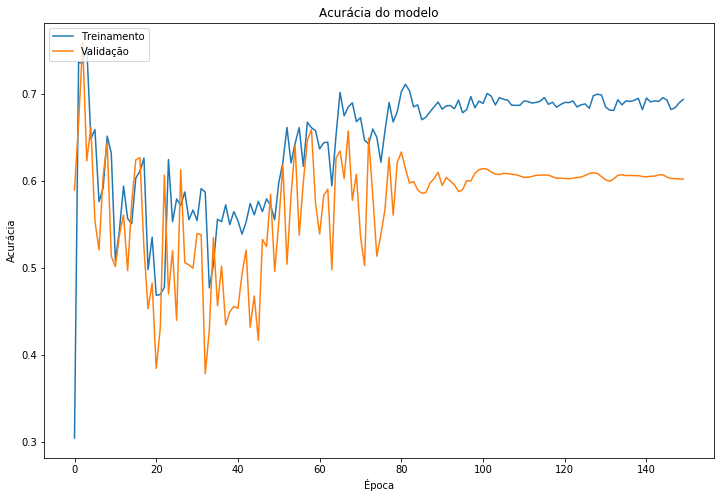

<Figure size 432x288 with 0 Axes>

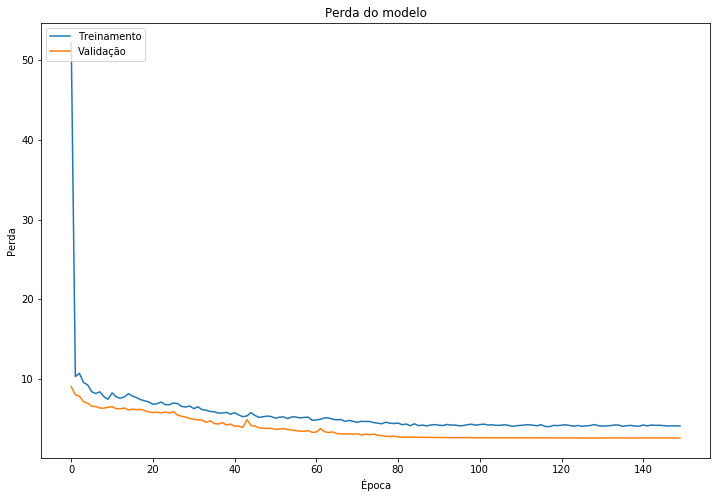

<Figure size 432x288 with 0 Axes>

In [19]:
# Visualização gráfica do treinamento e dos valores da acurácia da validação
plt.figure(figsize=[12, 8])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Acurácia do modelo')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.legend(['Treinamento', 'Validação'], loc='upper left')
plt.show()
# Salva o gráfico em uma imagem .png
plt.savefig('acuracia_modelo.png')

# Visualização gráfica do treinamento e dos valores da perda na validação
plt.figure(figsize=[12, 8])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Perda do modelo')
plt.ylabel('Perda')
plt.xlabel('Época')
plt.legend(['Treinamento', 'Validação'], loc='upper left')
plt.show()
# Salva o gráfico em uma imagem .png
plt.savefig('perda_modelo.png')

__Por que a perda do treinamento é muito maior que a perda dos testes?__

Um modelo Keras possui dois modos: treinamento e teste. Mecanismos de regularização, como Dropout e regularização de pesos L1/L2 são desligados em tempo de teste.

Além disso, a perda durante o treinamento é a média das perdas ao longo de cada batch do treinamento dos dados. As perdas nas primeiras batches de uma época são, geralmente, maiores que nas últimas batches. Por outro lado, a perda em teste de uma época é computada utilizando o modelo ao final da época, o que resulta em uma perda mais baixa.

## 6. Realizando predições

Agora, serão realizadas predições no conjunto de imagens de teste com o modelo treinado. Por conveniência, os geradores de teste serão utilizados da mesma maneira como foram setados acima. 

In [20]:
# 1: Seta o conjunto de dados de teste
test_dataset  = DataGenerator(load_images_into_memory=True, hdf5_dataset_path=None, labels_output_format=('class_id', 'xmin', 'ymin', 'xmax', 'ymax'))

test_dataset.parse_xml(images_dirs=[IVM_imgs_dir],
                       image_set_filenames=[IVM_general_test,
                                            IVM_all_test,
                                            IVM_all_split_test,
                                            IVM_cns_test,
                                            IVM_cns_unseen_test_test,
                                            IVM_selected_frames_test],
                       annotations_dirs=[IVM_anno_dir],
                       classes=classes,
                       include_classes='all',
                       exclude_truncated=False,
                       exclude_difficult=True,
                       ret=False)

# 2: Seta o gerador para as predições
predict_generator = test_dataset.generate(batch_size=10,
                                          shuffle=True,
                                          transformations=[convert_to_3_channels,
                                                           resize],
                                          label_encoder=None,
                                          returns={'processed_images',
                                                   'filenames',
                                                   'inverse_transform',
                                                   'original_images',
                                                   'original_labels'},
                                          keep_images_without_gt=False)

# 3: Gera exemplos
batch_images, batch_filenames, batch_inverse_transforms, batch_original_images, batch_original_labels = next(predict_generator)

print(batch_filenames)

#iter é a variável que diz qual o batch de imagens olhar
for iter in range(9):
    print("Image:", batch_filenames[iter])
    print()
    print("Ground truth boxes:\n")
    print(np.array(batch_original_labels[iter]))
    print('\n')

# 4: Realiza as predições
y_pred = model.predict(batch_images)

Loading images into memory: 100%|██████████| 9/9 [00:00<00:00, 73.89it/s]
['dataset/frames/Foto-0012_1.jpg', 'dataset/frames/vd_2_codec_v1_t001_0000.jpg', 'dataset/frames/vd_3_codec_v1_t001_0000.jpg', 'dataset/frames/control-2-medula-curva-inflamada-0014_t010024.jpg', 'dataset/frames/Foto-0015.jpg', 'dataset/frames/control-2-medula-curva-inflamada-0023_t0010008.jpg', 'dataset/frames/vd_1_codec_v1_t001_0000.jpg', 'dataset/frames/Foto-0105.jpg', 'dataset/frames/Foto-0023_1.jpg']
Image: dataset/frames/Foto-0012_1.jpg

Ground truth boxes:

[[   1  531  104  551  126]
 [   1  480  153  503  176]
 [   1  507  214  531  239]
 [   1  803  119  851  167]
 [   1  719  156  758  194]
 [   1  530  427  554  452]
 [   1  547  415  570  436]
 [   1  635  558  653  576]
 [   1  658  562  681  584]
 [   1  607  609  632  638]
 [   1  592  702  605  718]
 [   1  592  748  620  780]
 [   1  899  603  940  643]
 [   1  665  848  686  872]
 [   1  428  339  465  375]
 [   1  665  958  686  984]
 [   1  66

Agora, será necessário decodificar as predições puras em `y_pred`.

Caso o modelo tenha sido criado em __inference__ mode, a camada final do modelo seria `DecodeDetections` e `y_pred` já conteria as predições codificadas. Porém, visto que o modelo foi criado em __training__ mode, o model resulta, como saída, predições "Puras" que ainda precisam ser codificadas e filtradas. A função `decode_detections()` é responsável por isso. 

`decode_detections()` segue o procedimento original do SSD: inicialmente, um valor muito baixo de confiança de threshold (0.01) é aplicado, de maneira a filtrar a maior parte das caixas de predição. Em seguida, é aplicada NMS (non-maximum suppression) em cada classe com um threshold IoU (intersection-over-union) de 0.45 e, a partir dos restantes, as 200 bounding boxes com maior confiança sao retornadas. 
Para conseguir boas predições finais, será setado um threshold de confiança maior - 0.5

In [21]:
# 5: Decodifica as predições puras em 'y_pred'
y_pred_decoded = decode_detections(y_pred,
                                   confidence_thresh=0.25,
                                   iou_threshold=0.5,
                                   top_k=200,
                                   normalize_coords=normalize_coords,
                                   img_height=img_height,
                                   img_width=img_width)

Visto que as predições foram realizadas nas imagens reformatadas e que a visualização se dará no formato das imagens originais de entrada, é necessário converter as coordenadas apropriadamente.

A função `apply_inverse_transforms()` apenas aplica `original_image_size / resized_image_size` às coordenadas da caixa.

In [22]:
# 6: Converte as proedições para a imagem original
y_pred_decoded_inv = apply_inverse_transforms(y_pred_decoded, batch_inverse_transforms)

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
for iter in range(9):
    print(y_pred_decoded_inv[iter])
    print()

Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[   1.      0.62  592.    753.    614.    777.  ]
 [   1.      0.61 1137.    685.   1191.    729.  ]
 [   1.      0.6   711.    152.    759.    197.  ]
 [   1.      0.6   520.    356.    555.    392.  ]
 [   1.      0.58  608.    613.    632.    639.  ]
 [   1.      0.57  589.    698.    608.    721.  ]
 [   1.      0.57  525.    422.    557.    456.  ]
 [   1.      0.47  898.    599.    944.    645.  ]
 [   1.      0.43  765.    246.    809.    284.  ]
 [   1.      0.4   808.    121.    850.    164.  ]
 [   1.      0.39  640.    557.    666.    580.  ]
 [   1.      0.36  601.    582.    626.    608.  ]
 [   1.      0.35 1107.    685.   1168.    729.  ]
 [   1.      0.34  659.    561.    684.    585.  ]
 [   1.      0.33  525.    100.    553.    130.  ]
 [   1.      0.3  1084.    789.   1145.    835.  ]
 [   1.      0.3  1062.    799.   1125.    842.  ]
 [   1.      0.3   669.    756.    693.    783.  ]]

[[  1.     0.75 243.

Por último, basta desenhar as caixas de predição na imagem. Cada caixa de predição diz qual sua probabilidade de confiança ao lado do nome da categoria. As bounding boxes também serão desenhadas em verde por comparação.

['dataset/frames/Foto-0012_1.jpg', 'dataset/frames/vd_2_codec_v1_t001_0000.jpg', 'dataset/frames/vd_3_codec_v1_t001_0000.jpg', 'dataset/frames/control-2-medula-curva-inflamada-0014_t010024.jpg', 'dataset/frames/Foto-0015.jpg', 'dataset/frames/control-2-medula-curva-inflamada-0023_t0010008.jpg', 'dataset/frames/vd_1_codec_v1_t001_0000.jpg', 'dataset/frames/Foto-0105.jpg', 'dataset/frames/Foto-0023_1.jpg']


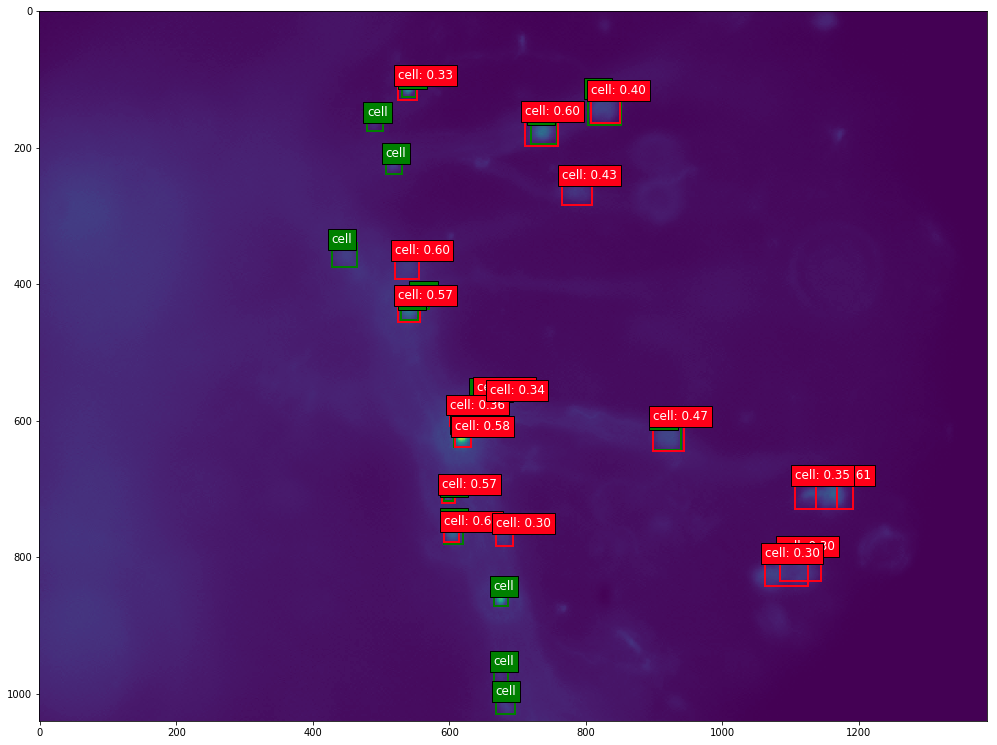

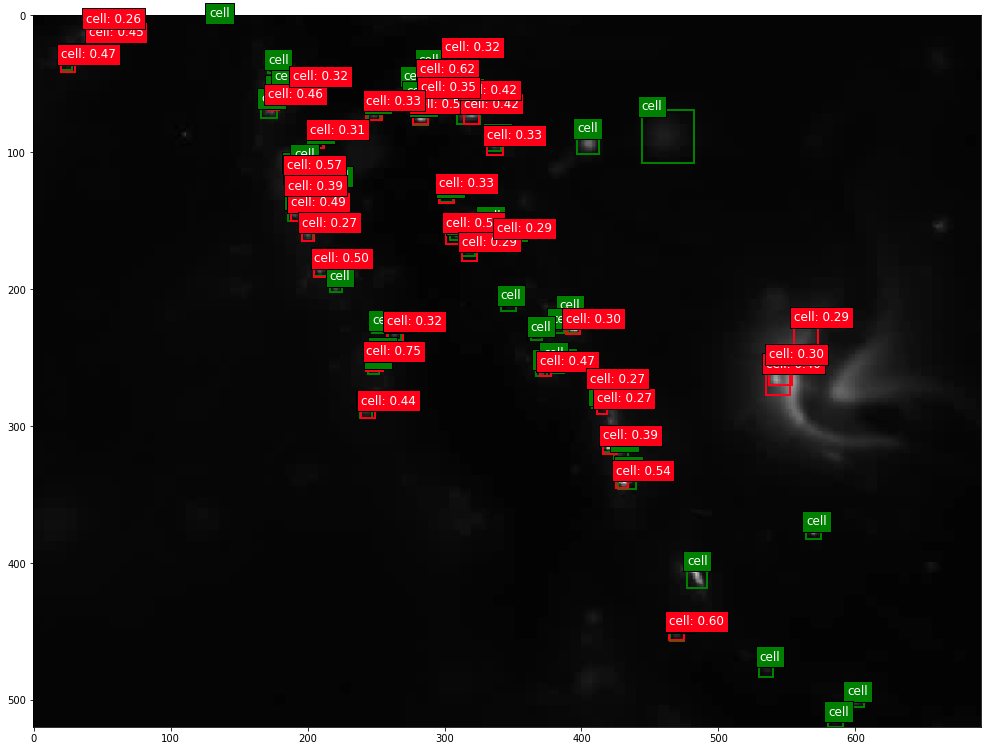

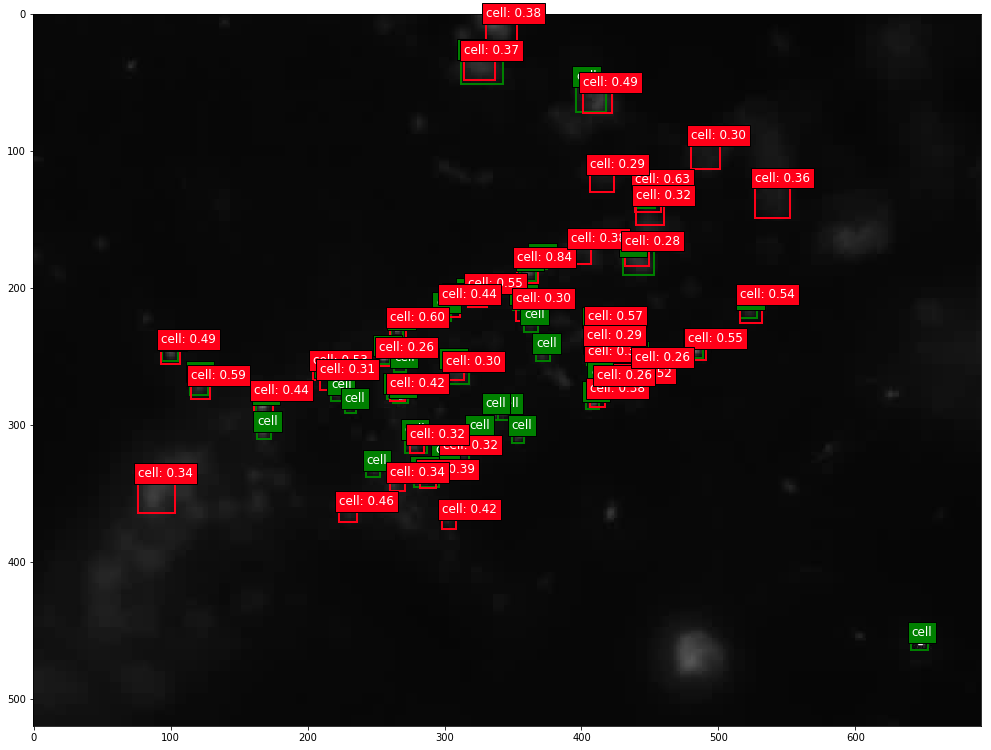

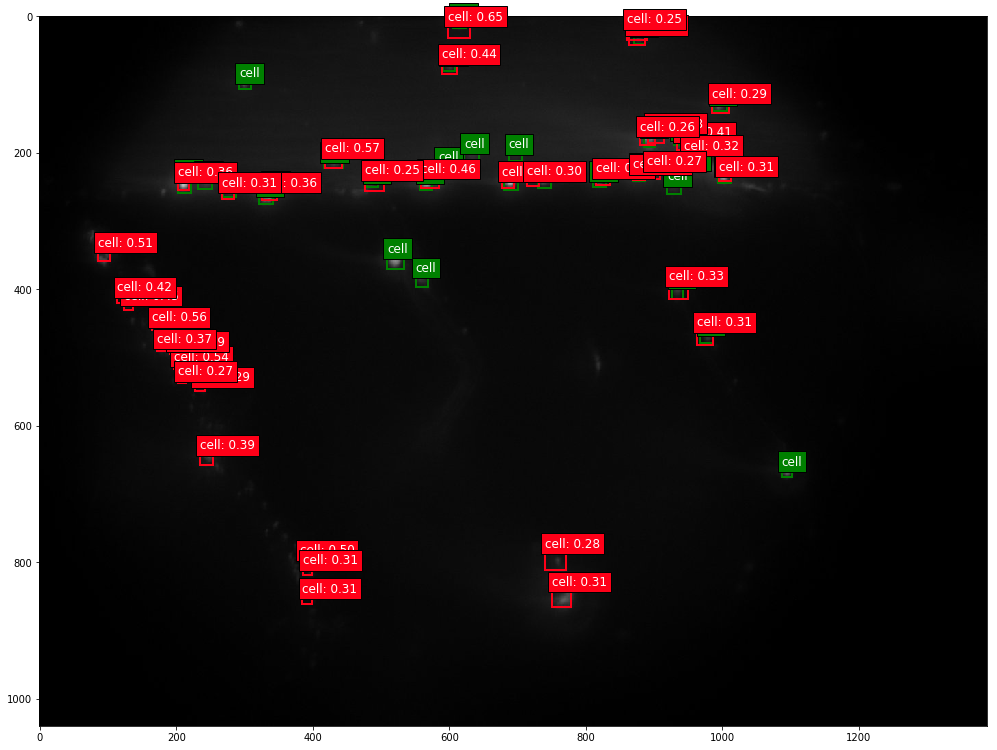

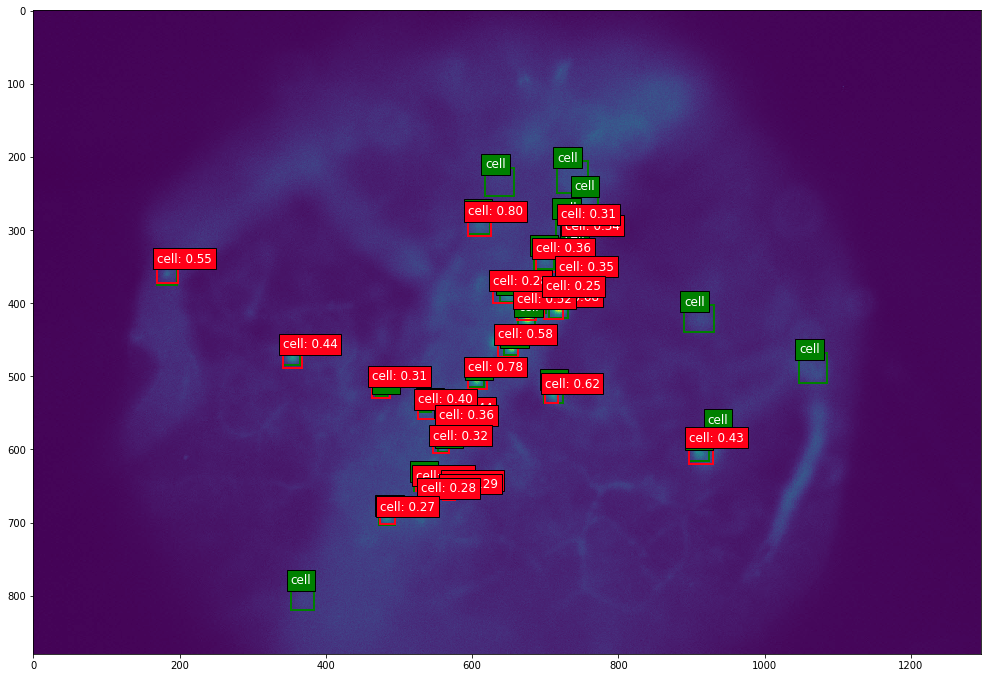

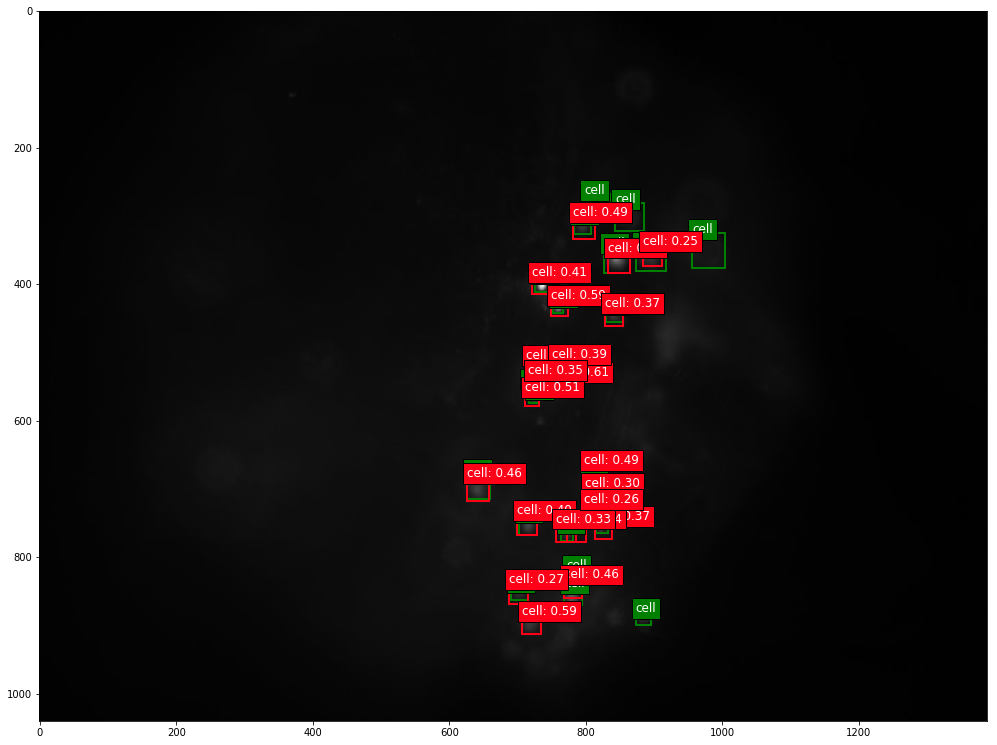

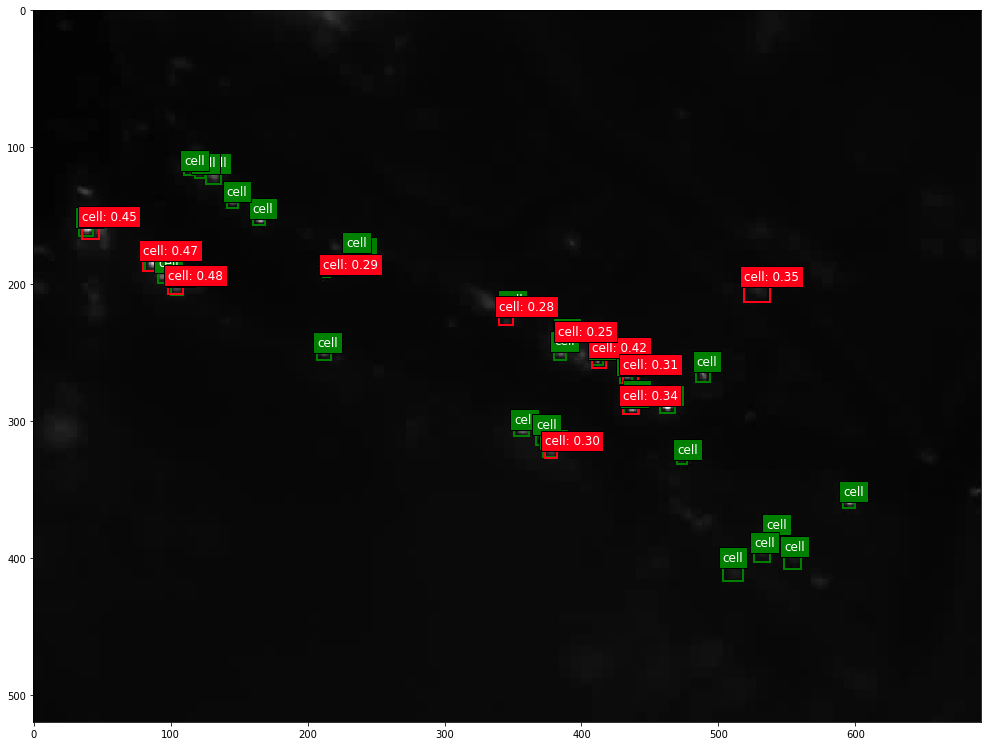

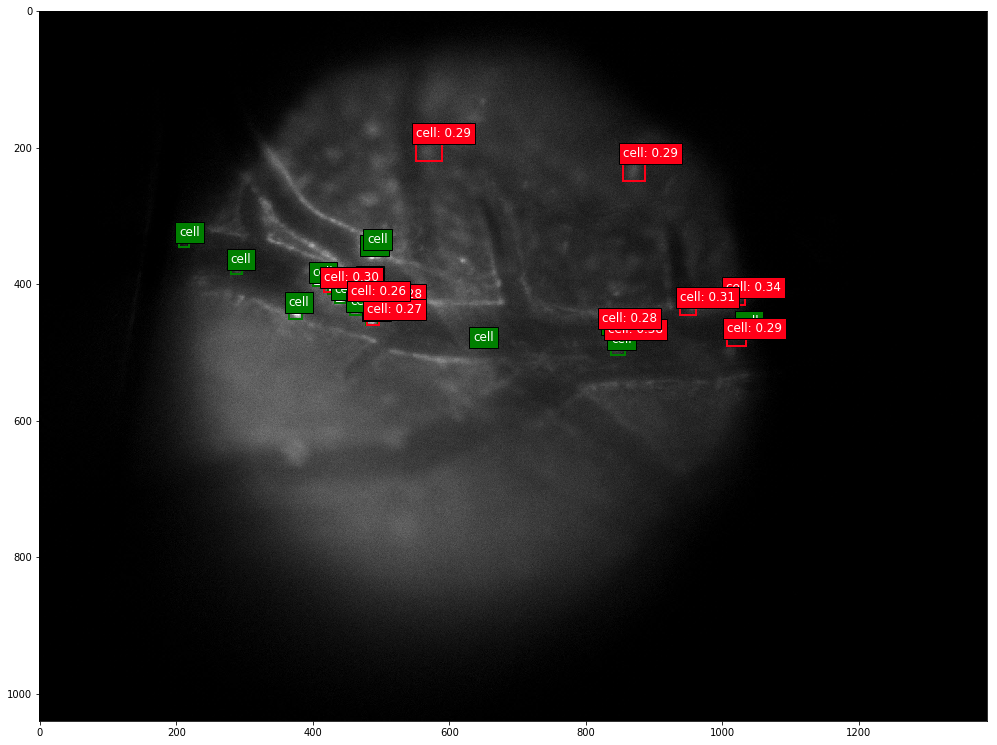

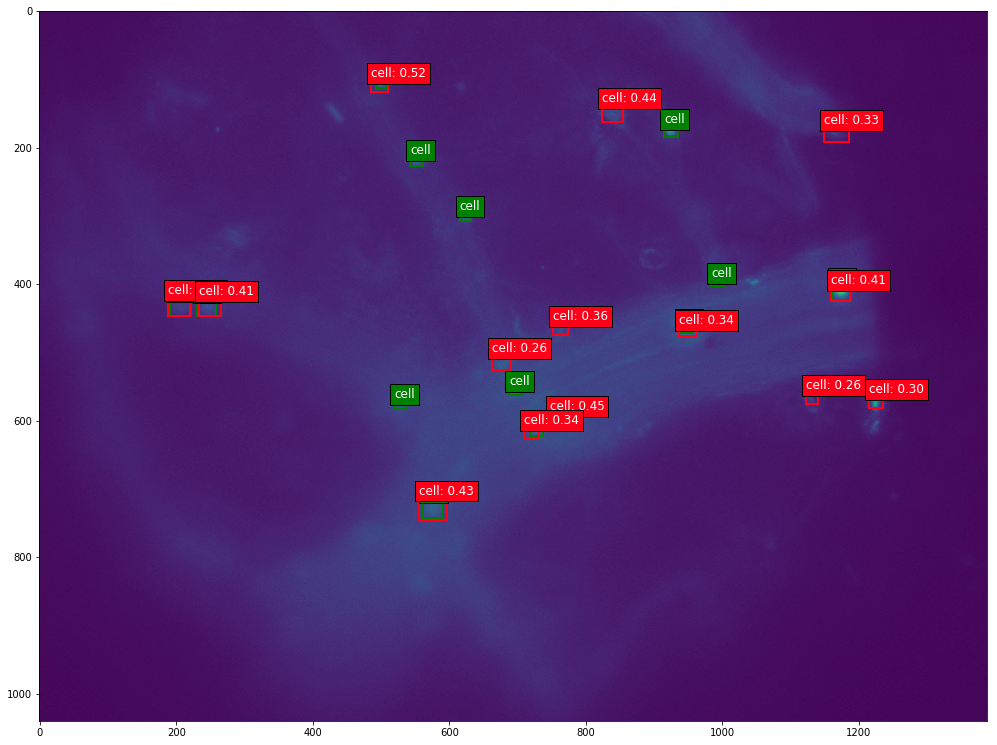

In [23]:
# 7: Desenhar as caixas de predição nas imagens

# Seta as cores das bounding boxes
colors = plt.cm.hsv(np.linspace(0, 1, n_classes+1)).tolist()
classes = ['background', 'cell']
print(batch_filenames)

for iter in range(9):
    plt.figure(figsize=(180, 108))
    plt.subplot(1, 9, iter + 1)
    plt.imshow(batch_original_images[iter])

    current_axis = plt.gca()

    for box in batch_original_labels[iter]:
        xmin = box[1]
        ymin = box[2]
        xmax = box[3]
        ymax = box[4]
        label = '{}'.format(classes[int(box[0])])
        current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='green', fill=False, linewidth=2))
        current_axis.text(xmin, ymin, label, size='large', color='white', bbox={'facecolor':'green', 'alpha':1.0})

    for box in y_pred_decoded_inv[iter]:

        xmin = box[2]
        ymin = box[3]
        xmax = box[4]
        ymax = box[5]
        color = colors[int(box[0])]
        label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
        current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))
        current_axis.text(xmin, ymin, label, size='large', color='white', bbox={'facecolor':color, 'alpha':1.0})

    # Salva as imagens com as boundings boxes e as caixas de predição  
    #plt.savefig('./Images_predicted/output{}'.format(iter))